In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow as tf

In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow_hub as hub
from datetime import datetime

In [4]:
!pip install bert-tensorflow==1.0.1

     |████████████████████████████████| 71kB 3.1MB/s 


In [5]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

In [6]:
# Set the output directory for saving model file
# Optionally, set a GCP bucket location

OUTPUT_DIR = 'OUTPUT_DIR_NAME3'#@param {type:"string"}
#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = True #@param {type:"boolean"}
#@markdown Set USE_BUCKET and BUCKET if you want to (optionally) store model output on GCP bucket.
USE_BUCKET = False #@param {type:"boolean"}
BUCKET = 'BUCKET_NAME' #@param {type:"string"}

if USE_BUCKET:
  OUTPUT_DIR = 'gs://{}/{}'.format(BUCKET, OUTPUT_DIR)
  from google.colab import auth
  auth.authenticate_user()

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    # Doesn't matter if the directory didn't exist
    pass
tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: OUTPUT_DIR_NAME3 *****


In [8]:
train = pd.read_csv('/content/colab-min-data.csv', sep=",", encoding='Latin-1')

In [9]:
train.head

<bound method NDFrame.head of        user_id  prod_id  rating  ...  total day_of_week title_word_count
0         5415      228       5  ...    NaN         NaN              NaN
1         8757      228       5  ...    NaN         NaN              NaN
2        55117      228       5  ...    NaN         NaN              NaN
3        55118      228       5  ...    NaN         NaN              NaN
4        55119      228       5  ...    NaN         NaN              NaN
...        ...      ...     ...  ...    ...         ...              ...
16365    41730      157       4  ...    NaN         NaN              NaN
16366    56031      157       3  ...    NaN         NaN              NaN
16367    76458      157       4  ...    NaN         NaN              NaN
16368    20334      157       4  ...    NaN         NaN              NaN
16369    72258      157       4  ...    NaN         NaN              NaN

[16370 rows x 22 columns]>

In [10]:
train.loc[train.label == 1, 'label'] = 0
train.loc[train.label == -1, 'label'] = 1

In [11]:
train['date'] = pd.to_datetime(train['date'])

In [12]:
train['day_of_week'] = train['date'].dt.day_name()

In [13]:
train.day_of_week.value_counts()[:10]

Sunday       2568
Monday       2557
Tuesday      2391
Thursday     2287
Friday       2231
Wednesday    2205
Saturday     2131
Name: day_of_week, dtype: int64

In [14]:
dofw = train.day_of_week.unique()

In [15]:
for day in range(len(dofw)):
        label=train['label'][train.day_of_week == dofw[day]]
        fake=len(label[label==1])
        real=len(label[label==0])
        
        print("***********Day is ",dofw[day])
        print("fake is ",fake)
        print("real is ",real)
        print("tot is ",fake+real)
        print("Ratio is ",100*(fake/(fake+real)))
        print("len is ",len(label))

***********Day is  Thursday
fake is  1425
real is  862
tot is  2287
Ratio is  62.30870135548754
len is  2287
***********Day is  Sunday
fake is  1439
real is  1129
tot is  2568
Ratio is  56.035825545171335
len is  2568
***********Day is  Wednesday
fake is  1338
real is  867
tot is  2205
Ratio is  60.68027210884354
len is  2205
***********Day is  Tuesday
fake is  1441
real is  950
tot is  2391
Ratio is  60.2676704307821
len is  2391
***********Day is  Saturday
fake is  1234
real is  897
tot is  2131
Ratio is  57.90708587517598
len is  2131
***********Day is  Monday
fake is  1502
real is  1055
tot is  2557
Ratio is  58.74071177160736
len is  2557
***********Day is  Friday
fake is  1390
real is  841
tot is  2231
Ratio is  62.30389959659346
len is  2231


In [16]:
import string
train['char_count'] = train['review'].apply(len)

In [17]:
train['word_count'] = train['review'].apply(lambda x: len(x.split()))

In [18]:
train['word_density'] = train['char_count'] / (train['word_count']+1)

In [19]:
train['punctuation_count'] = train['review'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))

In [20]:
train['title_word_count'] = train['review'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))

In [21]:
train['upper_case_word_count'] = train['review'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [22]:
train['date'] = pd.to_datetime(train['date'])
train['day_of_week'] = train['date'].dt.day_name()
#train.day_of_week.value_counts()[:10]]
dofw = train.day_of_week.unique()
for day in range(len(dofw)):
        label=train['label'][train.day_of_week == dofw[day]]
        fake=len(label[label==1])
        real=len(label[label==0])
        
        print("***********Day is ",dofw[day])
        print("fake is ",fake)
        print("real is ",real)
        print("tot is ",fake+real)
        print("len is ",len(label))

***********Day is  Thursday
fake is  1425
real is  862
tot is  2287
len is  2287
***********Day is  Sunday
fake is  1439
real is  1129
tot is  2568
len is  2568
***********Day is  Wednesday
fake is  1338
real is  867
tot is  2205
len is  2205
***********Day is  Tuesday
fake is  1441
real is  950
tot is  2391
len is  2391
***********Day is  Saturday
fake is  1234
real is  897
tot is  2131
len is  2131
***********Day is  Monday
fake is  1502
real is  1055
tot is  2557
len is  2557
***********Day is  Friday
fake is  1390
real is  841
tot is  2231
len is  2231


In [23]:
train['user_id_no_of_review'] = train.groupby('user_id')['user_id'].transform('size')

In [24]:
train['user_id_ave_rating'] = train.groupby('user_id')['rating'].transform('mean')

In [25]:
train['user_id_ave_no_words'] = train.groupby('user_id')['word_count'].transform('mean')
train['user_id_max_review_a_day'] = train['user_id_no_of_review']
grouped = train.groupby('user_id')

In [26]:
for name,group in grouped:
    #print(name)
    #print(group)
    df2 = group.groupby('date').size().max()
    #print(df2)
    train.loc[train.user_id == name,'user_id_max_review_a_day'] = df2
    #group['user_id_max_review_a_day']=df2

In [27]:
train['prod_id_no_of_review'] = train.groupby('prod_id')['prod_id'].transform('size') + 1000.
train['prod_id_ave_rating'] = train.groupby('prod_id')['rating'].transform('mean') + 1000.
#train['prod_id_std_rating'] = train.groupby('prod_id')['rating'].transform('std') + 1000.
train['prod_id_ave_no_words'] = train.groupby('prod_id')['word_count'].transform('mean') + 1000.
train['prod_id_max_review_a_day'] = train['prod_id_no_of_review'] + 1000.
grouped = train.groupby('prod_id')

In [28]:
train['total']=train.user_id.astype(str) + ' '+ train.prod_id.astype(str) + ' ' + train.rating.astype(str) + ' '+ \
train.user_id_no_of_review.astype(str) + ' ' + train.user_id_ave_rating.astype(str) + ' '+\
train.user_id_ave_no_words.astype(str) + ' ' + train.user_id_max_review_a_day.astype(str) + ' '+\
train.prod_id_no_of_review.astype(str) + ' ' + train.prod_id_ave_rating.astype(str) + ' '+\
train.prod_id_ave_no_words.astype(str) + ' ' + train.prod_id_max_review_a_day.astype(str) + ' '+\
train.day_of_week.astype(str) + ' '+train.review  

In [29]:
train.columns

Index(['user_id', 'prod_id', 'rating', 'label', 'date', 'review', 'char_count',
       'word_count', 'upper_case_word_count', 'word_density',
       'punctuation_count', 'user_id_no_of_review', 'user_id_ave_rating',
       'user_id_ave_no_words', 'user_id_max_review_a_day',
       'prod_id_no_of_review', 'prod_id_ave_rating', 'prod_id_ave_no_words',
       'prod_id_max_review_a_day', 'total', 'day_of_week', 'title_word_count'],
      dtype='object')

In [30]:
from sklearn.utils import shuffle
train = shuffle(train, random_state=0)

In [31]:
train.shape

(16370, 22)

In [32]:
test = train[7001:12000]
valid = train[12001:]
train = train[:7000]

In [33]:
DATA_COLUMN = 'total'
LABEL_COLUMN = 'label'
# label_list is the list of labels, i.e. True, False or 0, 1 or 'dog', 'cat'
label_list = [0, 1]

In [34]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [35]:
valid_InputExamples = valid.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [36]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [37]:
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 7000


INFO:tensorflow:Writing example 0 of 7000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 87 ##16 ##2 43 ##9 4 1 4 . 0 74 . 0 1 109 ##4 . 0 100 ##3 . 93 ##6 ##17 ##0 ##21 ##27 ##66 109 ##9 . 45 ##7 ##44 ##6 ##80 ##85 ##10 ##7 209 ##4 . 0 sunday dear owner of soc ##o restaurant , please consider expanding to dc . i promise we ' ll welcome you with open arms ! the food was great , vibe is cool , and i swear the hi ##bis ##cus tea must have crack in it because i ordered 6 of them . i went for sunday br ##un ##ch while visiting ny and fell in love . i had the red velvet chicken and wa ##ffle plate , the sweet wings [SEP]


INFO:tensorflow:tokens: [CLS] 87 ##16 ##2 43 ##9 4 1 4 . 0 74 . 0 1 109 ##4 . 0 100 ##3 . 93 ##6 ##17 ##0 ##21 ##27 ##66 109 ##9 . 45 ##7 ##44 ##6 ##80 ##85 ##10 ##7 209 ##4 . 0 sunday dear owner of soc ##o restaurant , please consider expanding to dc . i promise we ' ll welcome you with open arms ! the food was great , vibe is cool , and i swear the hi ##bis ##cus tea must have crack in it because i ordered 6 of them . i went for sunday br ##un ##ch while visiting ny and fell in love . i had the red velvet chicken and wa ##ffle plate , the sweet wings [SEP]


INFO:tensorflow:input_ids: 101 6584 16048 2475 4724 2683 1018 1015 1018 1012 1014 6356 1012 1014 1015 11518 2549 1012 1014 2531 2509 1012 6109 2575 16576 2692 17465 22907 28756 11518 2683 1012 3429 2581 22932 2575 17914 27531 10790 2581 19348 2549 1012 1014 4465 6203 3954 1997 27084 2080 4825 1010 3531 5136 9186 2000 5887 1012 1045 4872 2057 1005 2222 6160 2017 2007 2330 2608 999 1996 2833 2001 2307 1010 21209 2003 4658 1010 1998 1045 8415 1996 7632 18477 7874 5572 2442 2031 8579 1999 2009 2138 1045 3641 1020 1997 2068 1012 1045 2253 2005 4465 7987 4609 2818 2096 5873 6396 1998 3062 1999 2293 1012 1045 2018 1996 2417 10966 7975 1998 11333 18142 5127 1010 1996 4086 4777 102


INFO:tensorflow:input_ids: 101 6584 16048 2475 4724 2683 1018 1015 1018 1012 1014 6356 1012 1014 1015 11518 2549 1012 1014 2531 2509 1012 6109 2575 16576 2692 17465 22907 28756 11518 2683 1012 3429 2581 22932 2575 17914 27531 10790 2581 19348 2549 1012 1014 4465 6203 3954 1997 27084 2080 4825 1010 3531 5136 9186 2000 5887 1012 1045 4872 2057 1005 2222 6160 2017 2007 2330 2608 999 1996 2833 2001 2307 1010 21209 2003 4658 1010 1998 1045 8415 1996 7632 18477 7874 5572 2442 2031 8579 1999 2009 2138 1045 3641 1020 1997 2068 1012 1045 2253 2005 4465 7987 4609 2818 2096 5873 6396 1998 3062 1999 2293 1012 1045 2018 1996 2417 10966 7975 1998 11333 18142 5127 1010 1996 4086 4777 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 405 ##6 36 ##3 5 2 4 . 5 51 . 5 1 307 ##5 . 0 100 ##3 . 99 ##0 ##36 ##14 ##45 ##7 ##8 ##32 111 ##4 . 980 ##24 ##0 ##9 ##6 ##38 ##55 ##5 407 ##5 . 0 wednesday i wandered in here for late breakfast on a saturday because i was in soho and hadn ' t eaten yet . i had the buck ##w ##hea ##t cr ##ep ##es with scrambled eggs , ham and gr ##uy ##ere . it was good and definitely hit the spot - but next time i would probably try something else . i hear the sunday br ##un ##ch is better and my friend rave ##s about their french onion soup so i [SEP]


INFO:tensorflow:tokens: [CLS] 405 ##6 36 ##3 5 2 4 . 5 51 . 5 1 307 ##5 . 0 100 ##3 . 99 ##0 ##36 ##14 ##45 ##7 ##8 ##32 111 ##4 . 980 ##24 ##0 ##9 ##6 ##38 ##55 ##5 407 ##5 . 0 wednesday i wandered in here for late breakfast on a saturday because i was in soho and hadn ' t eaten yet . i had the buck ##w ##hea ##t cr ##ep ##es with scrambled eggs , ham and gr ##uy ##ere . it was good and definitely hit the spot - but next time i would probably try something else . i hear the sunday br ##un ##ch is better and my friend rave ##s about their french onion soup so i [SEP]


INFO:tensorflow:input_ids: 101 23988 2575 4029 2509 1019 1016 1018 1012 1019 4868 1012 1019 1015 24559 2629 1012 1014 2531 2509 1012 5585 2692 21619 16932 19961 2581 2620 16703 11118 2549 1012 25195 18827 2692 2683 2575 22025 24087 2629 28941 2629 1012 1014 9317 1045 13289 1999 2182 2005 2397 6350 2006 1037 5095 2138 1045 2001 1999 23771 1998 2910 1005 1056 8828 2664 1012 1045 2018 1996 10131 2860 20192 2102 13675 13699 2229 2007 13501 6763 1010 10654 1998 24665 26230 7869 1012 2009 2001 2204 1998 5791 2718 1996 3962 1011 2021 2279 2051 1045 2052 2763 3046 2242 2842 1012 1045 2963 1996 4465 7987 4609 2818 2003 2488 1998 2026 2767 23289 2015 2055 2037 2413 20949 11350 2061 1045 102


INFO:tensorflow:input_ids: 101 23988 2575 4029 2509 1019 1016 1018 1012 1019 4868 1012 1019 1015 24559 2629 1012 1014 2531 2509 1012 5585 2692 21619 16932 19961 2581 2620 16703 11118 2549 1012 25195 18827 2692 2683 2575 22025 24087 2629 28941 2629 1012 1014 9317 1045 13289 1999 2182 2005 2397 6350 2006 1037 5095 2138 1045 2001 1999 23771 1998 2910 1005 1056 8828 2664 1012 1045 2018 1996 10131 2860 20192 2102 13675 13699 2229 2007 13501 6763 1010 10654 1998 24665 26230 7869 1012 2009 2001 2204 1998 5791 2718 1996 3962 1011 2021 2279 2051 1045 2052 2763 3046 2242 2842 1012 1045 2963 1996 4465 7987 4609 2818 2003 2488 1998 2026 2767 23289 2015 2055 2037 2413 20949 11350 2061 1045 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 73 ##46 ##6 351 5 1 5 . 0 29 . 0 1 151 ##9 . 0 100 ##3 . 93 ##25 ##6 ##26 ##20 ##42 ##39 110 ##2 . 93 ##8 ##34 ##29 ##6 ##7 ##24 ##48 251 ##9 . 0 monday rude service . cr ##ammed tables . med ##io ##cre food . no substitution ##s on the menu - - not even easy ones . furniture and table ##ware in bad condition . dirty bathroom - - yu ##ck ! not going back . [SEP]


INFO:tensorflow:tokens: [CLS] 73 ##46 ##6 351 5 1 5 . 0 29 . 0 1 151 ##9 . 0 100 ##3 . 93 ##25 ##6 ##26 ##20 ##42 ##39 110 ##2 . 93 ##8 ##34 ##29 ##6 ##7 ##24 ##48 251 ##9 . 0 monday rude service . cr ##ammed tables . med ##io ##cre food . no substitution ##s on the menu - - not even easy ones . furniture and table ##ware in bad condition . dirty bathroom - - yu ##ck ! not going back . [SEP]


INFO:tensorflow:input_ids: 101 6421 21472 2575 28474 1019 1015 1019 1012 1014 2756 1012 1014 1015 16528 2683 1012 1014 2531 2509 1012 6109 17788 2575 23833 11387 20958 23499 7287 2475 1012 6109 2620 22022 24594 2575 2581 18827 18139 22582 2683 1012 1014 6928 12726 2326 1012 13675 27479 7251 1012 19960 3695 16748 2833 1012 2053 20885 2015 2006 1996 12183 1011 1011 2025 2130 3733 3924 1012 7390 1998 2795 8059 1999 2919 4650 1012 6530 5723 1011 1011 9805 3600 999 2025 2183 2067 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 6421 21472 2575 28474 1019 1015 1019 1012 1014 2756 1012 1014 1015 16528 2683 1012 1014 2531 2509 1012 6109 17788 2575 23833 11387 20958 23499 7287 2475 1012 6109 2620 22022 24594 2575 2581 18827 18139 22582 2683 1012 1014 6928 12726 2326 1012 13675 27479 7251 1012 19960 3695 16748 2833 1012 2053 20885 2015 2006 1996 12183 1011 1011 2025 2130 3733 3924 1012 7390 1998 2795 8059 1999 2919 4650 1012 6530 5723 1011 1011 9805 3600 999 2025 2183 2067 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 124 ##8 ##1 356 1 1 1 . 0 28 . 0 1 111 ##4 . 0 100 ##3 . 93 ##85 ##9 ##64 ##9 ##12 ##28 110 ##1 . 71 ##9 ##29 ##8 ##24 ##56 ##14 211 ##4 . 0 sunday does all the simple things right . good vibe . reasonable prices . at ##ten ##tive staff . good music . i ' m too young to be a regular here but this is a quality joint . [SEP]


INFO:tensorflow:tokens: [CLS] 124 ##8 ##1 356 1 1 1 . 0 28 . 0 1 111 ##4 . 0 100 ##3 . 93 ##85 ##9 ##64 ##9 ##12 ##28 110 ##1 . 71 ##9 ##29 ##8 ##24 ##56 ##14 211 ##4 . 0 sunday does all the simple things right . good vibe . reasonable prices . at ##ten ##tive staff . good music . i ' m too young to be a regular here but this is a quality joint . [SEP]


INFO:tensorflow:input_ids: 101 13412 2620 2487 27509 1015 1015 1015 1012 1014 2654 1012 1014 1015 11118 2549 1012 1014 2531 2509 1012 6109 27531 2683 21084 2683 12521 22407 7287 2487 1012 6390 2683 24594 2620 18827 26976 16932 19235 2549 1012 1014 4465 2515 2035 1996 3722 2477 2157 1012 2204 21209 1012 9608 7597 1012 2012 6528 6024 3095 1012 2204 2189 1012 1045 1005 1049 2205 2402 2000 2022 1037 3180 2182 2021 2023 2003 1037 3737 4101 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 13412 2620 2487 27509 1015 1015 1015 1012 1014 2654 1012 1014 1015 11118 2549 1012 1014 2531 2509 1012 6109 27531 2683 21084 2683 12521 22407 7287 2487 1012 6390 2683 24594 2620 18827 26976 16932 19235 2549 1012 1014 4465 2515 2035 1996 3722 2477 2157 1012 2204 21209 1012 9608 7597 1012 2012 6528 6024 3095 1012 2204 2189 1012 1045 1005 1049 2205 2402 2000 2022 1037 3180 2182 2021 2023 2003 1037 3737 4101 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 83 ##41 ##4 41 ##4 3 1 3 . 0 76 . 0 1 119 ##4 . 0 100 ##3 . 75 ##7 ##7 ##31 ##9 ##58 ##7 ##6 ##29 108 ##5 . 350 ##51 ##54 ##6 ##39 ##17 ##4 219 ##4 . 0 wednesday i like the concept . the meat ##balls are good . i had the chicken meat ##balls with pest ##o sauce and a side of mas ##hed potatoes . it was on top of a delicious ar ##ug ##ula salad with vegetables . i also had an ice cream sand ##w ##hic ##h . the prices are fair . you can go in there and fill yourself up with really good food for under 15 bucks . if anyone is in [SEP]


INFO:tensorflow:tokens: [CLS] 83 ##41 ##4 41 ##4 3 1 3 . 0 76 . 0 1 119 ##4 . 0 100 ##3 . 75 ##7 ##7 ##31 ##9 ##58 ##7 ##6 ##29 108 ##5 . 350 ##51 ##54 ##6 ##39 ##17 ##4 219 ##4 . 0 wednesday i like the concept . the meat ##balls are good . i had the chicken meat ##balls with pest ##o sauce and a side of mas ##hed potatoes . it was on top of a delicious ar ##ug ##ula salad with vegetables . i also had an ice cream sand ##w ##hic ##h . the prices are fair . you can go in there and fill yourself up with really good food for under 15 bucks . if anyone is in [SEP]


INFO:tensorflow:input_ids: 101 6640 23632 2549 4601 2549 1017 1015 1017 1012 1014 6146 1012 1014 1015 13285 2549 1012 1014 2531 2509 1012 4293 2581 2581 21486 2683 27814 2581 2575 24594 10715 2629 1012 8698 22203 27009 2575 23499 16576 2549 20636 2549 1012 1014 9317 1045 2066 1996 4145 1012 1996 6240 18510 2024 2204 1012 1045 2018 1996 7975 6240 18510 2007 20739 2080 12901 1998 1037 2217 1997 16137 9072 14629 1012 2009 2001 2006 2327 1997 1037 12090 12098 15916 7068 16521 2007 11546 1012 1045 2036 2018 2019 3256 6949 5472 2860 16066 2232 1012 1996 7597 2024 4189 1012 2017 2064 2175 1999 2045 1998 6039 4426 2039 2007 2428 2204 2833 2005 2104 2321 14189 1012 2065 3087 2003 1999 102


INFO:tensorflow:input_ids: 101 6640 23632 2549 4601 2549 1017 1015 1017 1012 1014 6146 1012 1014 1015 13285 2549 1012 1014 2531 2509 1012 4293 2581 2581 21486 2683 27814 2581 2575 24594 10715 2629 1012 8698 22203 27009 2575 23499 16576 2549 20636 2549 1012 1014 9317 1045 2066 1996 4145 1012 1996 6240 18510 2024 2204 1012 1045 2018 1996 7975 6240 18510 2007 20739 2080 12901 1998 1037 2217 1997 16137 9072 14629 1012 2009 2001 2006 2327 1997 1037 12090 12098 15916 7068 16521 2007 11546 1012 1045 2036 2018 2019 3256 6949 5472 2860 16066 2232 1012 1996 7597 2024 4189 1012 2017 2064 2175 1999 2045 1998 6039 4426 2039 2007 2428 2204 2833 2005 2104 2321 14189 1012 2065 3087 2003 1999 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


In [38]:
valid_features = bert.run_classifier.convert_examples_to_features(valid_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 4369


INFO:tensorflow:Writing example 0 of 4369


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 41 ##6 ##2 250 5 3 5 . 0 152 . 0 2 113 ##8 . 0 100 ##4 . 333 ##33 ##33 ##33 ##33 ##34 110 ##9 . 43 ##47 ##8 ##26 ##0 ##86 ##9 ##57 213 ##8 . 0 tuesday we went here for our first year anniversary together . the first and only time i ' ve had french food was 13 years ago , while i was in france . this was the first time outside of a cr ##ois ##sant or two that i was eating french food in nyc . we ordered the roasted bee ##t salad and soft shell crab as app ##eti ##zers . i enjoyed the bee ##t salad but thought that the crab tasted more italian [SEP]


INFO:tensorflow:tokens: [CLS] 41 ##6 ##2 250 5 3 5 . 0 152 . 0 2 113 ##8 . 0 100 ##4 . 333 ##33 ##33 ##33 ##33 ##34 110 ##9 . 43 ##47 ##8 ##26 ##0 ##86 ##9 ##57 213 ##8 . 0 tuesday we went here for our first year anniversary together . the first and only time i ' ve had french food was 13 years ago , while i was in france . this was the first time outside of a cr ##ois ##sant or two that i was eating french food in nyc . we ordered the roasted bee ##t salad and soft shell crab as app ##eti ##zers . i enjoyed the bee ##t salad but thought that the crab tasted more italian [SEP]


INFO:tensorflow:input_ids: 101 4601 2575 2475 5539 1019 1017 1019 1012 1014 15017 1012 1014 1016 12104 2620 1012 1014 2531 2549 1012 21211 22394 22394 22394 22394 22022 7287 2683 1012 4724 22610 2620 23833 2692 20842 2683 28311 19883 2620 1012 1014 9857 2057 2253 2182 2005 2256 2034 2095 5315 2362 1012 1996 2034 1998 2069 2051 1045 1005 2310 2018 2413 2833 2001 2410 2086 3283 1010 2096 1045 2001 1999 2605 1012 2023 2001 1996 2034 2051 2648 1997 1037 13675 10054 22341 2030 2048 2008 1045 2001 5983 2413 2833 1999 16392 1012 2057 3641 1996 28115 10506 2102 16521 1998 3730 5806 18081 2004 10439 20624 16750 1012 1045 5632 1996 10506 2102 16521 2021 2245 2008 1996 18081 12595 2062 3059 102


INFO:tensorflow:input_ids: 101 4601 2575 2475 5539 1019 1017 1019 1012 1014 15017 1012 1014 1016 12104 2620 1012 1014 2531 2549 1012 21211 22394 22394 22394 22394 22022 7287 2683 1012 4724 22610 2620 23833 2692 20842 2683 28311 19883 2620 1012 1014 9857 2057 2253 2182 2005 2256 2034 2095 5315 2362 1012 1996 2034 1998 2069 2051 1045 1005 2310 2018 2413 2833 2001 2410 2086 3283 1010 2096 1045 2001 1999 2605 1012 2023 2001 1996 2034 2051 2648 1997 1037 13675 10054 22341 2030 2048 2008 1045 2001 5983 2413 2833 1999 16392 1012 2057 3641 1996 28115 10506 2102 16521 1998 3730 5806 18081 2004 10439 20624 16750 1012 1045 5632 1996 10506 2102 16521 2021 2245 2008 1996 18081 12595 2062 3059 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 56 ##48 ##0 43 ##9 5 2 5 . 0 209 . 0 2 109 ##4 . 0 100 ##3 . 93 ##6 ##17 ##0 ##21 ##27 ##66 109 ##9 . 45 ##7 ##44 ##6 ##80 ##85 ##10 ##7 209 ##4 . 0 wednesday by far one of my favorite spots my first choice for date nice would like if they honor ur open table reservation even tho ur running late the lobster shrimp & grit ##s om ##g . . . . . . . . . . . . . . the red velvet wa ##ffle ##s with butter ##mi ##lk fried chicken - heaven - & the mac and cheese - yes ##ss ##ss ##ss ##s god jam ##bala ##ya hmm ##mm ##m [SEP]


INFO:tensorflow:tokens: [CLS] 56 ##48 ##0 43 ##9 5 2 5 . 0 209 . 0 2 109 ##4 . 0 100 ##3 . 93 ##6 ##17 ##0 ##21 ##27 ##66 109 ##9 . 45 ##7 ##44 ##6 ##80 ##85 ##10 ##7 209 ##4 . 0 wednesday by far one of my favorite spots my first choice for date nice would like if they honor ur open table reservation even tho ur running late the lobster shrimp & grit ##s om ##g . . . . . . . . . . . . . . the red velvet wa ##ffle ##s with butter ##mi ##lk fried chicken - heaven - & the mac and cheese - yes ##ss ##ss ##ss ##s god jam ##bala ##ya hmm ##mm ##m [SEP]


INFO:tensorflow:input_ids: 101 5179 18139 2692 4724 2683 1019 1016 1019 1012 1014 19348 1012 1014 1016 11518 2549 1012 1014 2531 2509 1012 6109 2575 16576 2692 17465 22907 28756 11518 2683 1012 3429 2581 22932 2575 17914 27531 10790 2581 19348 2549 1012 1014 9317 2011 2521 2028 1997 2026 5440 7516 2026 2034 3601 2005 3058 3835 2052 2066 2065 2027 3932 24471 2330 2795 11079 2130 27793 24471 2770 2397 1996 27940 20130 1004 24842 2015 18168 2290 1012 1012 1012 1012 1012 1012 1012 1012 1012 1012 1012 1012 1012 1012 1996 2417 10966 11333 18142 2015 2007 12136 4328 13687 13017 7975 1011 6014 1011 1004 1996 6097 1998 8808 1011 2748 4757 4757 4757 2015 2643 9389 25060 3148 17012 7382 2213 102


INFO:tensorflow:input_ids: 101 5179 18139 2692 4724 2683 1019 1016 1019 1012 1014 19348 1012 1014 1016 11518 2549 1012 1014 2531 2509 1012 6109 2575 16576 2692 17465 22907 28756 11518 2683 1012 3429 2581 22932 2575 17914 27531 10790 2581 19348 2549 1012 1014 9317 2011 2521 2028 1997 2026 5440 7516 2026 2034 3601 2005 3058 3835 2052 2066 2065 2027 3932 24471 2330 2795 11079 2130 27793 24471 2770 2397 1996 27940 20130 1004 24842 2015 18168 2290 1012 1012 1012 1012 1012 1012 1012 1012 1012 1012 1012 1012 1012 1012 1996 2417 10966 11333 18142 2015 2007 12136 4328 13687 13017 7975 1011 6014 1011 1004 1996 6097 1998 8808 1011 2748 4757 4757 4757 2015 2643 9389 25060 3148 17012 7382 2213 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 70 ##53 ##7 330 5 1 5 . 0 112 . 0 1 102 ##6 . 0 100 ##3 . 38 ##46 ##15 ##38 ##46 ##15 ##4 111 ##4 . 80 ##7 ##6 ##9 ##23 ##0 ##7 ##6 ##9 ##24 202 ##6 . 0 saturday cafe ##cit ##o is a wonderful restaurant , great bar with excellent drinks , and a perfect place for me to un ##wind after a long day at work or to begin my night on the weekend . the food quality is excellent , the mo ##jit ##os to die for , and the management is incredibly friendly and professional . i love the steak sandwich with delicious plant ##ain chips made in house accompanied by a fresh garlic mo ##jit [SEP]


INFO:tensorflow:tokens: [CLS] 70 ##53 ##7 330 5 1 5 . 0 112 . 0 1 102 ##6 . 0 100 ##3 . 38 ##46 ##15 ##38 ##46 ##15 ##4 111 ##4 . 80 ##7 ##6 ##9 ##23 ##0 ##7 ##6 ##9 ##24 202 ##6 . 0 saturday cafe ##cit ##o is a wonderful restaurant , great bar with excellent drinks , and a perfect place for me to un ##wind after a long day at work or to begin my night on the weekend . the food quality is excellent , the mo ##jit ##os to die for , and the management is incredibly friendly and professional . i love the steak sandwich with delicious plant ##ain chips made in house accompanied by a fresh garlic mo ##jit [SEP]


INFO:tensorflow:input_ids: 101 3963 22275 2581 14210 1019 1015 1019 1012 1014 11176 1012 1014 1015 9402 2575 1012 1014 2531 2509 1012 4229 21472 16068 22025 21472 16068 2549 11118 2549 1012 3770 2581 2575 2683 21926 2692 2581 2575 2683 18827 16798 2575 1012 1014 5095 7668 26243 2080 2003 1037 6919 4825 1010 2307 3347 2007 6581 8974 1010 1998 1037 3819 2173 2005 2033 2000 4895 11101 2044 1037 2146 2154 2012 2147 2030 2000 4088 2026 2305 2006 1996 5353 1012 1996 2833 3737 2003 6581 1010 1996 9587 18902 2891 2000 3280 2005 1010 1998 1996 2968 2003 11757 5379 1998 2658 1012 1045 2293 1996 21475 11642 2007 12090 3269 8113 11772 2081 1999 2160 5642 2011 1037 4840 20548 9587 18902 102


INFO:tensorflow:input_ids: 101 3963 22275 2581 14210 1019 1015 1019 1012 1014 11176 1012 1014 1015 9402 2575 1012 1014 2531 2509 1012 4229 21472 16068 22025 21472 16068 2549 11118 2549 1012 3770 2581 2575 2683 21926 2692 2581 2575 2683 18827 16798 2575 1012 1014 5095 7668 26243 2080 2003 1037 6919 4825 1010 2307 3347 2007 6581 8974 1010 1998 1037 3819 2173 2005 2033 2000 4895 11101 2044 1037 2146 2154 2012 2147 2030 2000 4088 2026 2305 2006 1996 5353 1012 1996 2833 3737 2003 6581 1010 1996 9587 18902 2891 2000 3280 2005 1010 1998 1996 2968 2003 11757 5379 1998 2658 1012 1045 2293 1996 21475 11642 2007 12090 3269 8113 11772 2081 1999 2160 5642 2011 1037 4840 20548 9587 18902 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 76 ##10 ##5 36 ##3 5 1 5 . 0 149 . 0 1 307 ##5 . 0 100 ##3 . 99 ##0 ##36 ##14 ##45 ##7 ##8 ##32 111 ##4 . 980 ##24 ##0 ##9 ##6 ##38 ##55 ##5 407 ##5 . 0 thursday i have one tradition when i visit new york - i go to soho and have lunch at balthazar . it started in the 90 ' s when the art scene was still happening , before the galleries closed their doors and migrated to chelsea . at the time it was considered the ultimate hot spot , with lots of celebrities and no way to get a reservation . i went once and was lucky enough to sit in the bar [SEP]


INFO:tensorflow:tokens: [CLS] 76 ##10 ##5 36 ##3 5 1 5 . 0 149 . 0 1 307 ##5 . 0 100 ##3 . 99 ##0 ##36 ##14 ##45 ##7 ##8 ##32 111 ##4 . 980 ##24 ##0 ##9 ##6 ##38 ##55 ##5 407 ##5 . 0 thursday i have one tradition when i visit new york - i go to soho and have lunch at balthazar . it started in the 90 ' s when the art scene was still happening , before the galleries closed their doors and migrated to chelsea . at the time it was considered the ultimate hot spot , with lots of celebrities and no way to get a reservation . i went once and was lucky enough to sit in the bar [SEP]


INFO:tensorflow:input_ids: 101 6146 10790 2629 4029 2509 1019 1015 1019 1012 1014 17332 1012 1014 1015 24559 2629 1012 1014 2531 2509 1012 5585 2692 21619 16932 19961 2581 2620 16703 11118 2549 1012 25195 18827 2692 2683 2575 22025 24087 2629 28941 2629 1012 1014 9432 1045 2031 2028 4535 2043 1045 3942 2047 2259 1011 1045 2175 2000 23771 1998 2031 6265 2012 25021 1012 2009 2318 1999 1996 3938 1005 1055 2043 1996 2396 3496 2001 2145 6230 1010 2077 1996 11726 2701 2037 4303 1998 13447 2000 9295 1012 2012 1996 2051 2009 2001 2641 1996 7209 2980 3962 1010 2007 7167 1997 12330 1998 2053 2126 2000 2131 1037 11079 1012 1045 2253 2320 1998 2001 5341 2438 2000 4133 1999 1996 3347 102


INFO:tensorflow:input_ids: 101 6146 10790 2629 4029 2509 1019 1015 1019 1012 1014 17332 1012 1014 1015 24559 2629 1012 1014 2531 2509 1012 5585 2692 21619 16932 19961 2581 2620 16703 11118 2549 1012 25195 18827 2692 2683 2575 22025 24087 2629 28941 2629 1012 1014 9432 1045 2031 2028 4535 2043 1045 3942 2047 2259 1011 1045 2175 2000 23771 1998 2031 6265 2012 25021 1012 2009 2318 1999 1996 3938 1005 1055 2043 1996 2396 3496 2001 2145 6230 1010 2077 1996 11726 2701 2037 4303 1998 13447 2000 9295 1012 2012 1996 2051 2009 2001 2641 1996 7209 2980 3962 1010 2007 7167 1997 12330 1998 2053 2126 2000 2131 1037 11079 1012 1045 2253 2320 1998 2001 5341 2438 2000 4133 1999 1996 3347 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 118 ##55 ##8 278 4 1 4 . 0 42 . 0 1 105 ##3 . 0 100 ##3 . 77 ##35 ##8 ##49 ##0 ##56 ##60 ##4 109 ##7 . 47 ##16 ##9 ##8 ##11 ##32 ##0 ##7 ##6 205 ##3 . 0 tuesday this place was very ta ##sty ! the fish ta ##co and em ##pan ##ada ##s were delicious but the pork ta ##co was just so - so . i had the margarita - sang ##ria was sweet and strong . the service was fast and everyone was polite . will definitely come back for round 2 ! [SEP]


INFO:tensorflow:tokens: [CLS] 118 ##55 ##8 278 4 1 4 . 0 42 . 0 1 105 ##3 . 0 100 ##3 . 77 ##35 ##8 ##49 ##0 ##56 ##60 ##4 109 ##7 . 47 ##16 ##9 ##8 ##11 ##32 ##0 ##7 ##6 205 ##3 . 0 tuesday this place was very ta ##sty ! the fish ta ##co and em ##pan ##ada ##s were delicious but the pork ta ##co was just so - so . i had the margarita - sang ##ria was sweet and strong . the service was fast and everyone was polite . will definitely come back for round 2 ! [SEP]


INFO:tensorflow:input_ids: 101 12963 24087 2620 24709 1018 1015 1018 1012 1014 4413 1012 1014 1015 8746 2509 1012 1014 2531 2509 1012 6255 19481 2620 26224 2692 26976 16086 2549 11518 2581 1012 4700 16048 2683 2620 14526 16703 2692 2581 2575 16327 2509 1012 1014 9857 2023 2173 2001 2200 11937 21756 999 1996 3869 11937 3597 1998 7861 9739 8447 2015 2020 12090 2021 1996 15960 11937 3597 2001 2074 2061 1011 2061 1012 1045 2018 1996 24570 1011 6369 4360 2001 4086 1998 2844 1012 1996 2326 2001 3435 1998 3071 2001 13205 1012 2097 5791 2272 2067 2005 2461 1016 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 12963 24087 2620 24709 1018 1015 1018 1012 1014 4413 1012 1014 1015 8746 2509 1012 1014 2531 2509 1012 6255 19481 2620 26224 2692 26976 16086 2549 11518 2581 1012 4700 16048 2683 2620 14526 16703 2692 2581 2575 16327 2509 1012 1014 9857 2023 2173 2001 2200 11937 21756 999 1996 3869 11937 3597 1998 7861 9739 8447 2015 2020 12090 2021 1996 15960 11937 3597 2001 2074 2061 1011 2061 1012 1045 2018 1996 24570 1011 6369 4360 2001 4086 1998 2844 1012 1996 2326 2001 3435 1998 3071 2001 13205 1012 2097 5791 2272 2067 2005 2461 1016 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


In [39]:
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 4999


INFO:tensorflow:Writing example 0 of 4999


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 159 ##01 36 ##3 2 1 2 . 0 74 . 0 1 307 ##5 . 0 100 ##3 . 99 ##0 ##36 ##14 ##45 ##7 ##8 ##32 111 ##4 . 980 ##24 ##0 ##9 ##6 ##38 ##55 ##5 407 ##5 . 0 monday possibly one of the most expensive restaurants i ' ve been too , but completely worth it . completely packed on a tuesday night , the waitress was wonderful , and when we had a problem with our food not being prepared to our liking , they brought us a whole new meal and gave us dessert on the house . i got the duck shepard ##s pie , which was delicious , the dessert we got was the chocolate mo ##uss [SEP]


INFO:tensorflow:tokens: [CLS] 159 ##01 36 ##3 2 1 2 . 0 74 . 0 1 307 ##5 . 0 100 ##3 . 99 ##0 ##36 ##14 ##45 ##7 ##8 ##32 111 ##4 . 980 ##24 ##0 ##9 ##6 ##38 ##55 ##5 407 ##5 . 0 monday possibly one of the most expensive restaurants i ' ve been too , but completely worth it . completely packed on a tuesday night , the waitress was wonderful , and when we had a problem with our food not being prepared to our liking , they brought us a whole new meal and gave us dessert on the house . i got the duck shepard ##s pie , which was delicious , the dessert we got was the chocolate mo ##uss [SEP]


INFO:tensorflow:input_ids: 101 18914 24096 4029 2509 1016 1015 1016 1012 1014 6356 1012 1014 1015 24559 2629 1012 1014 2531 2509 1012 5585 2692 21619 16932 19961 2581 2620 16703 11118 2549 1012 25195 18827 2692 2683 2575 22025 24087 2629 28941 2629 1012 1014 6928 4298 2028 1997 1996 2087 6450 7884 1045 1005 2310 2042 2205 1010 2021 3294 4276 2009 1012 3294 8966 2006 1037 9857 2305 1010 1996 13877 2001 6919 1010 1998 2043 2057 2018 1037 3291 2007 2256 2833 2025 2108 4810 2000 2256 16663 1010 2027 2716 2149 1037 2878 2047 7954 1998 2435 2149 18064 2006 1996 2160 1012 1045 2288 1996 9457 22189 2015 11345 1010 2029 2001 12090 1010 1996 18064 2057 2288 2001 1996 7967 9587 17854 102


INFO:tensorflow:input_ids: 101 18914 24096 4029 2509 1016 1015 1016 1012 1014 6356 1012 1014 1015 24559 2629 1012 1014 2531 2509 1012 5585 2692 21619 16932 19961 2581 2620 16703 11118 2549 1012 25195 18827 2692 2683 2575 22025 24087 2629 28941 2629 1012 1014 6928 4298 2028 1997 1996 2087 6450 7884 1045 1005 2310 2042 2205 1010 2021 3294 4276 2009 1012 3294 8966 2006 1037 9857 2305 1010 1996 13877 2001 6919 1010 1998 2043 2057 2018 1037 3291 2007 2256 2833 2025 2108 4810 2000 2256 16663 1010 2027 2716 2149 1037 2878 2047 7954 1998 2435 2149 18064 2006 1996 2160 1012 1045 2288 1996 9457 22189 2015 11345 1010 2029 2001 12090 1010 1996 18064 2057 2288 2001 1996 7967 9587 17854 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 120 ##50 ##6 60 ##7 4 1 4 . 0 345 . 0 1 105 ##6 . 0 100 ##4 . 339 ##28 ##57 ##14 ##28 ##57 109 ##9 . 1785 ##7 ##14 ##28 ##57 ##13 205 ##6 . 0 thursday very cozy little restaurant with more outdoor seating than indoors . the decor is very home ##y and displays photos and post ##cards i ' m assuming the owners received from their customers . this place is cash only , but they do have an atm next to the bathroom . for dinner , pat ##es et traditions offers various cr ##ep ##es , salad ##s , and pasta ##s . definitely go for the cr ##ep ##es as , in my opinion , they [SEP]


INFO:tensorflow:tokens: [CLS] 120 ##50 ##6 60 ##7 4 1 4 . 0 345 . 0 1 105 ##6 . 0 100 ##4 . 339 ##28 ##57 ##14 ##28 ##57 109 ##9 . 1785 ##7 ##14 ##28 ##57 ##13 205 ##6 . 0 thursday very cozy little restaurant with more outdoor seating than indoors . the decor is very home ##y and displays photos and post ##cards i ' m assuming the owners received from their customers . this place is cash only , but they do have an atm next to the bathroom . for dinner , pat ##es et traditions offers various cr ##ep ##es , salad ##s , and pasta ##s . definitely go for the cr ##ep ##es as , in my opinion , they [SEP]


INFO:tensorflow:input_ids: 101 6036 12376 2575 3438 2581 1018 1015 1018 1012 1014 23785 1012 1014 1015 8746 2575 1012 1014 2531 2549 1012 28977 22407 28311 16932 22407 28311 11518 2683 1012 17262 2581 16932 22407 28311 17134 16327 2575 1012 1014 9432 2200 26931 2210 4825 2007 2062 7254 10747 2084 24274 1012 1996 25545 2003 2200 2188 2100 1998 8834 7760 1998 2695 17965 1045 1005 1049 10262 1996 5608 2363 2013 2037 6304 1012 2023 2173 2003 5356 2069 1010 2021 2027 2079 2031 2019 27218 2279 2000 1996 5723 1012 2005 4596 1010 6986 2229 3802 7443 4107 2536 13675 13699 2229 1010 16521 2015 1010 1998 24857 2015 1012 5791 2175 2005 1996 13675 13699 2229 2004 1010 1999 2026 5448 1010 2027 102


INFO:tensorflow:input_ids: 101 6036 12376 2575 3438 2581 1018 1015 1018 1012 1014 23785 1012 1014 1015 8746 2575 1012 1014 2531 2549 1012 28977 22407 28311 16932 22407 28311 11518 2683 1012 17262 2581 16932 22407 28311 17134 16327 2575 1012 1014 9432 2200 26931 2210 4825 2007 2062 7254 10747 2084 24274 1012 1996 25545 2003 2200 2188 2100 1998 8834 7760 1998 2695 17965 1045 1005 1049 10262 1996 5608 2363 2013 2037 6304 1012 2023 2173 2003 5356 2069 1010 2021 2027 2079 2031 2019 27218 2279 2000 1996 5723 1012 2005 4596 1010 6986 2229 3802 7443 4107 2536 13675 13699 2229 1010 16521 2015 1010 1998 24857 2015 1012 5791 2175 2005 1996 13675 13699 2229 2004 1010 1999 2026 5448 1010 2027 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 700 ##6 ##1 61 ##4 5 1 5 . 0 129 . 0 1 103 ##7 . 0 100 ##3 . 97 ##29 ##7 ##29 ##7 ##29 ##7 ##3 107 ##2 . 75 ##6 ##75 ##6 ##75 ##6 ##75 ##6 ##7 203 ##7 . 0 thursday i went to miriam ' s expecting a nice time and maybe some food . my friend and i were in the area and decided we wanted to get a drink to cool down . then , we felt the racism of the staff . we were told that there was no space at the bar ( there were 3 stool ##s open ) and that we couldn ' t sit down because of their reservations ( it was 5 [SEP]


INFO:tensorflow:tokens: [CLS] 700 ##6 ##1 61 ##4 5 1 5 . 0 129 . 0 1 103 ##7 . 0 100 ##3 . 97 ##29 ##7 ##29 ##7 ##29 ##7 ##3 107 ##2 . 75 ##6 ##75 ##6 ##75 ##6 ##75 ##6 ##7 203 ##7 . 0 thursday i went to miriam ' s expecting a nice time and maybe some food . my friend and i were in the area and decided we wanted to get a drink to cool down . then , we felt the racism of the staff . we were told that there was no space at the bar ( there were 3 stool ##s open ) and that we couldn ' t sit down because of their reservations ( it was 5 [SEP]


INFO:tensorflow:input_ids: 101 6352 2575 2487 6079 2549 1019 1015 1019 1012 1014 14378 1012 1014 1015 9800 2581 1012 1014 2531 2509 1012 5989 24594 2581 24594 2581 24594 2581 2509 10550 2475 1012 4293 2575 23352 2575 23352 2575 23352 2575 2581 18540 2581 1012 1014 9432 1045 2253 2000 16925 1005 1055 8074 1037 3835 2051 1998 2672 2070 2833 1012 2026 2767 1998 1045 2020 1999 1996 2181 1998 2787 2057 2359 2000 2131 1037 4392 2000 4658 2091 1012 2059 1010 2057 2371 1996 14398 1997 1996 3095 1012 2057 2020 2409 2008 2045 2001 2053 2686 2012 1996 3347 1006 2045 2020 1017 14708 2015 2330 1007 1998 2008 2057 2481 1005 1056 4133 2091 2138 1997 2037 17829 1006 2009 2001 1019 102


INFO:tensorflow:input_ids: 101 6352 2575 2487 6079 2549 1019 1015 1019 1012 1014 14378 1012 1014 1015 9800 2581 1012 1014 2531 2509 1012 5989 24594 2581 24594 2581 24594 2581 2509 10550 2475 1012 4293 2575 23352 2575 23352 2575 23352 2575 2581 18540 2581 1012 1014 9432 1045 2253 2000 16925 1005 1055 8074 1037 3835 2051 1998 2672 2070 2833 1012 2026 2767 1998 1045 2020 1999 1996 2181 1998 2787 2057 2359 2000 2131 1037 4392 2000 4658 2091 1012 2059 1010 2057 2371 1996 14398 1997 1996 3095 1012 2057 2020 2409 2008 2045 2001 2053 2686 2012 1996 3347 1006 2045 2020 1017 14708 2015 2330 1007 1998 2008 2057 2481 1005 1056 4133 2091 2138 1997 2037 17829 1006 2009 2001 1019 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 74 ##24 ##4 35 ##3 5 1 5 . 0 197 . 0 1 1778 . 0 100 ##4 . 329 ##0 ##48 ##8 ##43 ##18 ##7 ##7 111 ##8 . 57 ##32 ##64 ##7 ##8 ##14 ##9 ##1 277 ##8 . 0 sunday it might be un ##wise to be a buzz - kill for a place as revered as luca ##li , but to be completely frank , the pizza did not live up to its billing , and certainly not its price . to be clear : the pizza here is excellent . but you ' ve had better , and if you haven ' t , you should keep looking . usually packed , i went most recently on a tuesday night [SEP]


INFO:tensorflow:tokens: [CLS] 74 ##24 ##4 35 ##3 5 1 5 . 0 197 . 0 1 1778 . 0 100 ##4 . 329 ##0 ##48 ##8 ##43 ##18 ##7 ##7 111 ##8 . 57 ##32 ##64 ##7 ##8 ##14 ##9 ##1 277 ##8 . 0 sunday it might be un ##wise to be a buzz - kill for a place as revered as luca ##li , but to be completely frank , the pizza did not live up to its billing , and certainly not its price . to be clear : the pizza here is excellent . but you ' ve had better , and if you haven ' t , you should keep looking . usually packed , i went most recently on a tuesday night [SEP]


INFO:tensorflow:input_ids: 101 6356 18827 2549 3486 2509 1019 1015 1019 1012 1014 19975 1012 1014 1015 16331 1012 1014 2531 2549 1012 29567 2692 18139 2620 23777 15136 2581 2581 11118 2620 1012 5401 16703 21084 2581 2620 16932 2683 2487 25578 2620 1012 1014 4465 2009 2453 2022 4895 14244 2000 2022 1037 12610 1011 3102 2005 1037 2173 2004 23886 2004 15604 3669 1010 2021 2000 2022 3294 3581 1010 1996 10733 2106 2025 2444 2039 2000 2049 25640 1010 1998 5121 2025 2049 3976 1012 2000 2022 3154 1024 1996 10733 2182 2003 6581 1012 2021 2017 1005 2310 2018 2488 1010 1998 2065 2017 4033 1005 1056 1010 2017 2323 2562 2559 1012 2788 8966 1010 1045 2253 2087 3728 2006 1037 9857 2305 102


INFO:tensorflow:input_ids: 101 6356 18827 2549 3486 2509 1019 1015 1019 1012 1014 19975 1012 1014 1015 16331 1012 1014 2531 2549 1012 29567 2692 18139 2620 23777 15136 2581 2581 11118 2620 1012 5401 16703 21084 2581 2620 16932 2683 2487 25578 2620 1012 1014 4465 2009 2453 2022 4895 14244 2000 2022 1037 12610 1011 3102 2005 1037 2173 2004 23886 2004 15604 3669 1010 2021 2000 2022 3294 3581 1010 1996 10733 2106 2025 2444 2039 2000 2049 25640 1010 1998 5121 2025 2049 3976 1012 2000 2022 3154 1024 1996 10733 2182 2003 6581 1012 2021 2017 1005 2310 2018 2488 1010 1998 2065 2017 4033 1005 1056 1010 2017 2323 2562 2559 1012 2788 8966 1010 1045 2253 2087 3728 2006 1037 9857 2305 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 61 ##85 ##0 54 ##8 4 1 4 . 0 43 . 0 1 110 ##5 . 0 100 ##3 . 91 ##42 ##85 ##7 ##14 ##28 ##57 106 ##8 . 05 ##7 ##14 ##28 ##57 ##14 ##3 210 ##5 . 0 tuesday it ' s my favorite place in korea town . they have cheap price with a variety of all the korean foods ! whenever i bring my friends , they love this place . it ' s also a best place to take out luc ##h box or to - go food for home . [SEP]


INFO:tensorflow:tokens: [CLS] 61 ##85 ##0 54 ##8 4 1 4 . 0 43 . 0 1 110 ##5 . 0 100 ##3 . 91 ##42 ##85 ##7 ##14 ##28 ##57 106 ##8 . 05 ##7 ##14 ##28 ##57 ##14 ##3 210 ##5 . 0 tuesday it ' s my favorite place in korea town . they have cheap price with a variety of all the korean foods ! whenever i bring my friends , they love this place . it ' s also a best place to take out luc ##h box or to - go food for home . [SEP]


INFO:tensorflow:input_ids: 101 6079 27531 2692 5139 2620 1018 1015 1018 1012 1014 4724 1012 1014 1015 7287 2629 1012 1014 2531 2509 1012 6205 20958 27531 2581 16932 22407 28311 10114 2620 1012 5709 2581 16932 22407 28311 16932 2509 12875 2629 1012 1014 9857 2009 1005 1055 2026 5440 2173 1999 4420 2237 1012 2027 2031 10036 3976 2007 1037 3528 1997 2035 1996 4759 9440 999 7188 1045 3288 2026 2814 1010 2027 2293 2023 2173 1012 2009 1005 1055 2036 1037 2190 2173 2000 2202 2041 12776 2232 3482 2030 2000 1011 2175 2833 2005 2188 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 6079 27531 2692 5139 2620 1018 1015 1018 1012 1014 4724 1012 1014 1015 7287 2629 1012 1014 2531 2509 1012 6205 20958 27531 2581 16932 22407 28311 10114 2620 1012 5709 2581 16932 22407 28311 16932 2509 12875 2629 1012 1014 9857 2009 1005 1055 2026 5440 2173 1999 4420 2237 1012 2027 2031 10036 3976 2007 1037 3528 1997 2035 1996 4759 9440 999 7188 1045 3288 2026 2814 1010 2027 2293 2023 2173 1012 2009 1005 1055 2036 1037 2190 2173 2000 2202 2041 12776 2232 3482 2030 2000 1011 2175 2833 2005 2188 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


In [40]:
valid

,user_id,prod_id,rating,label,date,review,char_count,word_count,upper_case_word_count,word_density,punctuation_count,user_id_no_of_review,user_id_ave_rating,user_id_ave_no_words,user_id_max_review_a_day,prod_id_no_of_review,prod_id_ave_rating,prod_id_ave_no_words,prod_id_max_review_a_day,total,day_of_week,title_word_count
516,4162,250,5,1,2014-02-25,We went here for our first year anniversary to...,1556,282,10,5.498233,40,3,5.0,152.0,2,1138.0,1004.333333,1109.434783,2138.0,4162 250 5 3 5.0 152.0 2 1138.0 1004.333333333...,Tuesday,34
7036,56480,439,5,1,2011-11-23,By far one of my favorite spots my first choic...,383,70,3,5.394366,22,2,5.0,209.0,2,1094.0,1003.936170,1099.457447,2094.0,56480 439 5 2 5.0 209.0 2 1094.0 1003.93617021...,Wednesday,7
3033,70537,330,5,1,2012-07-14,"Cafecito is a wonderful restaurant, great bar ...",652,112,2,5.769912,12,1,5.0,112.0,1,1026.0,1003.384615,1114.807692,2026.0,70537 330 5 1 5.0 112.0 1 1026.0 1003.38461538...,Saturday,6
15458,76105,363,5,0,2009-09-17,I have one tradition when I visit New York- I ...,839,149,5,5.593333,22,1,5.0,149.0,1,3075.0,1003.990361,1114.980241,4075.0,76105 363 5 1 5.0 149.0 1 3075.0 1003.99036144...,Thursday,19
8091,118558,278,4,1,2014-08-19,This place was very tasty! The fish taco and e...,238,42,1,5.534884,7,1,4.0,42.0,1,1053.0,1003.773585,1097.471698,2053.0,118558 278 4 1 4.0 42.0 1 1053.0 1003.77358490...,Tuesday,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,4181,632,4,1,2014-07-24,We wanted a real New York pizza and we found i...,187,34,0,5.342857,12,10,4.4,60.0,2,1056.0,1004.196429,1068.767857,2056.0,4181 632 4 10 4.4 60.0 2 1056.0 1004.196428571...,Thursday,5
3264,71687,674,5,1,2011-07-19,"We went here for the crepes, and it certainly ...",617,111,0,5.508929,22,1,5.0,111.0,1,1012.0,1004.750000,1096.666667,2012.0,71687 674 5 1 5.0 111.0 1 1012.0 1004.75 1096....,Tuesday,6
9845,73356,350,3,0,2014-06-09,"Gladys, you are great. Drinks: Sit at the bar ...",1139,206,4,5.502415,34,1,3.0,206.0,1,1075.0,1004.093333,1115.906667,2075.0,73356 350 3 1 3.0 206.0 1 1075.0 1004.09333333...,Monday,27
10799,73826,352,4,0,2013-07-15,Yummyyy! Love kati rolls! I've had the chicken...,342,67,3,5.029412,11,1,4.0,67.0,1,1694.0,1003.789625,1088.766571,2694.0,73826 352 4 1 4.0 67.0 1 1694.0 1003.789625360...,Monday,4


In [41]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.7)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [42]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        return {
            "eval_accuracy": accuracy,
            "f1_score": f1_score,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [43]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 2.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps train.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

In [44]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [45]:
num_train_steps

437

In [46]:
# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [47]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpupmjtpf5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f758cca8b90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpupmjtpf5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f758cca8b90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [48]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

In [49]:
print(f'Beginning Training!')
#current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ")

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:loss = 0.70491654, step = 1


INFO:tensorflow:loss = 0.70491654, step = 1


INFO:tensorflow:Saving checkpoints for 14 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 14 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 28 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 28 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 42 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 42 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 56 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 56 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 70 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 70 into /tmp/tmpupmjtpf5/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:Saving checkpoints for 84 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 84 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 98 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 98 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:global_step/sec: 0.0222399


INFO:tensorflow:global_step/sec: 0.0222399


INFO:tensorflow:loss = 0.25904164, step = 101 (4496.463 sec)


INFO:tensorflow:loss = 0.25904164, step = 101 (4496.463 sec)


INFO:tensorflow:Saving checkpoints for 111 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 111 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 125 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 125 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 139 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 139 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 153 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 153 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 167 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 167 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 181 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 181 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 195 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 195 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:global_step/sec: 0.0220149


INFO:tensorflow:global_step/sec: 0.0220149


INFO:tensorflow:loss = 0.24476098, step = 201 (4542.349 sec)


INFO:tensorflow:loss = 0.24476098, step = 201 (4542.349 sec)


INFO:tensorflow:Saving checkpoints for 209 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 209 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 223 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 223 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 237 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 237 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 251 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 251 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 265 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 265 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 279 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 279 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 293 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 293 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:global_step/sec: 0.0219547


INFO:tensorflow:global_step/sec: 0.0219547


INFO:tensorflow:loss = 0.22413605, step = 301 (4554.827 sec)


INFO:tensorflow:loss = 0.22413605, step = 301 (4554.827 sec)


INFO:tensorflow:Saving checkpoints for 307 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 307 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 321 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 321 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 335 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 335 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 349 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 349 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 363 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 363 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 377 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 377 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 391 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 391 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:global_step/sec: 0.0220629


INFO:tensorflow:global_step/sec: 0.0220629


INFO:tensorflow:loss = 0.032687135, step = 401 (4532.498 sec)


INFO:tensorflow:loss = 0.032687135, step = 401 (4532.498 sec)


INFO:tensorflow:Saving checkpoints for 405 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 405 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 419 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 419 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 433 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 433 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 437 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 437 into /tmp/tmpupmjtpf5/model.ckpt.


INFO:tensorflow:Loss for final step: 0.26725894.


INFO:tensorflow:Loss for final step: 0.26725894.


Training took time 


In [50]:
valid_input_fn = run_classifier.input_fn_builder(
    features=valid_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [51]:
estimator.evaluate(input_fn=valid_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-03-08T20:16:23Z


INFO:tensorflow:Starting evaluation at 2021-03-08T20:16:23Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpupmjtpf5/model.ckpt-437


INFO:tensorflow:Restoring parameters from /tmp/tmpupmjtpf5/model.ckpt-437


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2021-03-08-20:48:27


INFO:tensorflow:Finished evaluation at 2021-03-08-20:48:27


INFO:tensorflow:Saving dict for global step 437: auc = 0.95811623, eval_accuracy = 0.9498741, f1_score = 0.9572015, false_negatives = 212.0, false_positives = 7.0, global_step = 437, loss = 0.15714765, precision = 0.9971498, recall = 0.9203307, true_negatives = 1701.0, true_positives = 2449.0


INFO:tensorflow:Saving dict for global step 437: auc = 0.95811623, eval_accuracy = 0.9498741, f1_score = 0.9572015, false_negatives = 212.0, false_positives = 7.0, global_step = 437, loss = 0.15714765, precision = 0.9971498, recall = 0.9203307, true_negatives = 1701.0, true_positives = 2449.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 437: /tmp/tmpupmjtpf5/model.ckpt-437


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 437: /tmp/tmpupmjtpf5/model.ckpt-437


{'auc': 0.95811623,
 'eval_accuracy': 0.9498741,
 'f1_score': 0.9572015,
 'false_negatives': 212.0,
 'false_positives': 7.0,
 'global_step': 437,
 'loss': 0.15714765,
 'precision': 0.9971498,
 'recall': 0.9203307,
 'true_negatives': 1701.0,
 'true_positives': 2449.0}

In [54]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [55]:
estimator.evaluate(input_fn=test_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-03-08T20:51:54Z


INFO:tensorflow:Starting evaluation at 2021-03-08T20:51:54Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpupmjtpf5/model.ckpt-437


INFO:tensorflow:Restoring parameters from /tmp/tmpupmjtpf5/model.ckpt-437


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2021-03-08-21:27:57


INFO:tensorflow:Finished evaluation at 2021-03-08-21:27:57


INFO:tensorflow:Saving dict for global step 437: auc = 0.9569698, eval_accuracy = 0.9495899, f1_score = 0.9555241, false_negatives = 247.0, false_positives = 5.0, global_step = 437, loss = 0.15803981, precision = 0.99815637, recall = 0.9163846, true_negatives = 2040.0, true_positives = 2707.0


INFO:tensorflow:Saving dict for global step 437: auc = 0.9569698, eval_accuracy = 0.9495899, f1_score = 0.9555241, false_negatives = 247.0, false_positives = 5.0, global_step = 437, loss = 0.15803981, precision = 0.99815637, recall = 0.9163846, true_negatives = 2040.0, true_positives = 2707.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 437: /tmp/tmpupmjtpf5/model.ckpt-437


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 437: /tmp/tmpupmjtpf5/model.ckpt-437


{'auc': 0.9569698,
 'eval_accuracy': 0.9495899,
 'f1_score': 0.9555241,
 'false_negatives': 247.0,
 'false_positives': 5.0,
 'global_step': 437,
 'loss': 0.15803981,
 'precision': 0.99815637,
 'recall': 0.9163846,
 'true_negatives': 2040.0,
 'true_positives': 2707.0}

In [56]:
predictions = estimator.predict(test_input_fn)
#list(predictions)[0]
pred = pd.DataFrame(list(predictions))
pred.head()

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpupmjtpf5/model.ckpt-437


INFO:tensorflow:Restoring parameters from /tmp/tmpupmjtpf5/model.ckpt-437


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


,probabilities,labels
0,"[-0.07446306, -2.634453]",0
1,"[-5.9705033, -0.0025562725]",1
2,"[-0.17238678, -1.8429703]",0
3,"[-0.09522686, -2.3987284]",0
4,"[-5.7959676, -0.003044377]",1


In [57]:
pred[:100]

,probabilities,labels
0,"[-0.07446306, -2.634453]",0
1,"[-5.9705033, -0.0025562725]",1
2,"[-0.17238678, -1.8429703]",0
3,"[-0.09522686, -2.3987284]",0
4,"[-5.7959676, -0.003044377]",1
...,...,...
95,"[-0.17796595, -1.8138264]",0
96,"[-0.20513979, -1.6848805]",0
97,"[-5.8052254, -0.003016329]",1
98,"[-0.038750265, -3.269929]",0


In [58]:
import numpy as np
pred[['log_p0', 'log_p1']] = pd.DataFrame(pred.probabilities.tolist()) 
pred['p1']= np.exp(pred['log_p1'])

pred.head()

,probabilities,labels,log_p0,log_p1,p1
0,"[-0.07446306, -2.634453]",0,-0.074463,-2.634453,0.071758
1,"[-5.9705033, -0.0025562725]",1,-5.970503,-0.002556,0.997447
2,"[-0.17238678, -1.8429703]",0,-0.172387,-1.842970,0.158346
3,"[-0.09522686, -2.3987284]",0,-0.095227,-2.398728,0.090833
4,"[-5.7959676, -0.003044377]",1,-5.795968,-0.003044,0.996960


In [60]:
test = (test).reset_index()
(test.label == pred.labels).value_counts()

True     4746
False     253
dtype: int64

In [61]:
pred['true_labels'] = test.label
pred['abs_dif'] = np.abs(pred.true_labels-pred.p1)
pred['review'] = test['review']
pred.head()

,probabilities,labels,log_p0,log_p1,p1,true_labels,abs_dif,review
0,"[-0.07446306, -2.634453]",0,-0.074463,-2.634453,0.071758,0,0.071758,Possibly one of the most expensive restaurants...
1,"[-5.9705033, -0.0025562725]",1,-5.970503,-0.002556,0.997447,1,0.002553,Very cozy little restaurant with more outdoor ...
2,"[-0.17238678, -1.8429703]",0,-0.172387,-1.842970,0.158346,1,0.841654,I went to Miriam's expecting a nice time and m...
3,"[-0.09522686, -2.3987284]",0,-0.095227,-2.398728,0.090833,0,0.090833,It might be unwise to be a buzz-kill for a pla...
4,"[-5.7959676, -0.003044377]",1,-5.795968,-0.003044,0.996960,1,0.003040,It's my favorite place in Korea town. They hav...


In [62]:
pred.to_csv(r'/content/test-data-analysis.csv')

In [63]:
train.to_csv(r'/content/featured-mini.csv')

In [64]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(pred.true_labels , pred.p1)
auc = metrics.roc_auc_score(pred.true_labels , pred.p1)
print("Auc ROC is ",auc)
precision, recall, thresholds = metrics.precision_recall_curve(pred.true_labels , pred.p1)
auc = metrics.auc(recall, precision)
print("Auc PRC is ",auc)
f1 = metrics.f1_score(pred.true_labels, pred.labels)
print("F1 score is",f1)
print("Log loss is ",metrics.log_loss(pred.true_labels , pred.p1))

Auc ROC is  0.9694161329464172
Auc PRC is  0.9835544447277909
F1 score is 0.9553398058252427
Log loss is  0.15862500200258767


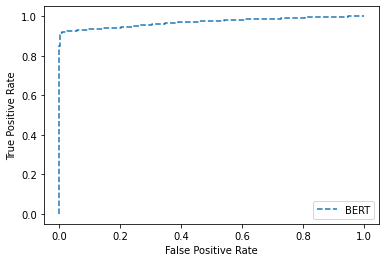

In [65]:
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, linestyle='--', label='BERT')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [68]:
results = pd.DataFrame()
results['prob'] = pred.p1
results['predictions'] = pred.labels
results['labels'] = pred.true_labels
results.to_csv('/content/BERT.csv') 